# Architecture - Semantic Search using Elastic Search

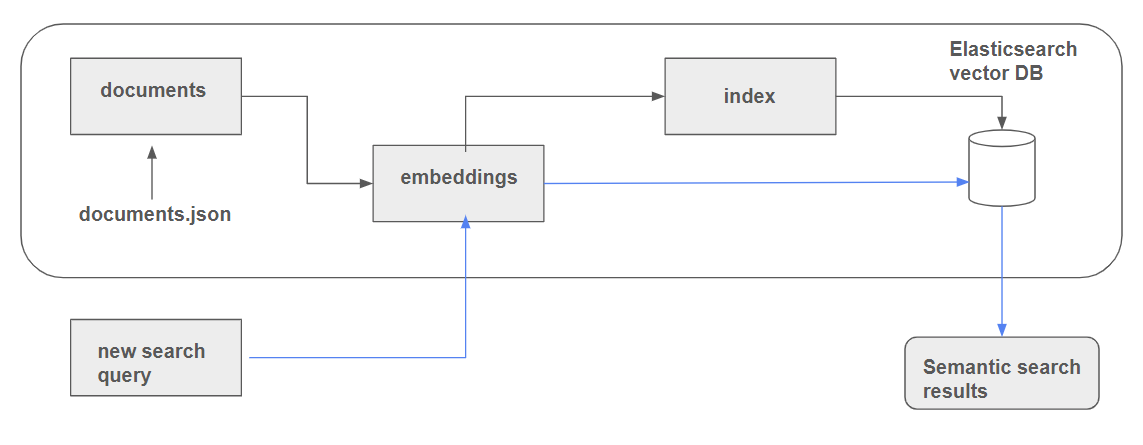

- A document is a collection of fields with their associated values.
- To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index.
- Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

In [2]:
import json
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch

## Step 1: Prepare documents

In [3]:
with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [4]:
documents = []

for course_dict in docs_raw:
    for doc in course_dict["documents"]:
        doc["course"] = course_dict["course"]
        documents.append(doc)

In [5]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

## Step 2: Create Embeddings using Pretrained Models

In [6]:
model = SentenceTransformer("all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
len(model.encode("This is a simple sentence"))

768

In [10]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

Embeddings will be performed only on the text field.

In [11]:
operations = []

for doc in documents:
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

In [12]:
operations[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'text_vector': [-0.04103041812777519,
  0.025834158062934875,
  -0.03680184856057167,
  -0.020898327231407166,
  -0.020596275106072426,
  0.009353749454021454,
  -0.0033317022025585175,
  -0.009491887874901295,
  0.030117960646748543,
  0.01908211223781109,
  0.012690017931163311,
  -0.01707877218723297,
  -0.0016324581811204553,
  0.12997248768806458,
  0.03096918575465679,
  -0.025823727250099182,
  0.02782304398715496,
  0.02515977807343006,
  -0.0808122381567955,
  -0.003617348847910762,
  -0.008902021683752537,
  0.003404838964343071,
  -0.023009272292256355,
  -0.034045297652482986,
  0.02459859289228916,
  0.013545563444495201,
  -0.025439007207751274,
  0.011951071210205555,
  -0.020540110766887665,
  -0.010077393613755703,
  0.020575352013111115,
 

## Step 3: Setup ElasticSearch connection

In [7]:
es_client = Elasticsearch('http://localhost:9200') 
es_client.info()

ObjectApiResponse({'name': '9f3bc72cc875', 'cluster_name': 'docker-cluster', 'cluster_uuid': '0s7BQnvcRa2EKe7hoHOYUQ', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

## Step 4: Create Mappings and Index

- Mapping is the process of defining how a document and the fields it contains, are stored and indexed.
- Each document is a collection of fields, which each have their own data type.
- We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the dataype of each field (e.g. string, integer, or date), and how those fields should be indexed and stored. 

In [13]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [14]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

## Step 5: Add documents into index

In [15]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

## Step 6: Create end user query

In [16]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [17]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [18]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'eM6BiJAB5diFC8nIPjDK',
  '_score': 0.71479195,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 'i86BiJAB5diFC8nIZzPA',
  '_score': 0.61347336,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares 

## Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [19]:
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [20]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5
)


In [21]:
response["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'eM6BiJAB5diFC8nIPjDK',
  '_score': 11.614713,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965469121932983,
    -0.0006261463859118521,
    -0.016629496589303017,
    0.052851490676403046,
    0.054765257984399796,
    -0.03133990615606308,
    0.02994258515536785,
    -0.04808564856648445,
    0.04467553272843361,
    0.00583944097161293,
    0.01623307541012764,
    0.012001145631074905,
    -0.031222272664308548,
    0.016600526869297028,
    -0.048869017511606216,
    -0.06496305763721466,
    0.04643421620130539,
    -0.009297734126448631,
    -0.06425285339355469,
    -0.01373270619660616,
    -0.01597622223198414,
    0.008629543706774712,
    -0.0244789868593

**References:**

1.https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2.https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3.https://www.elastic.co/search-labs/tutorials

4.https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch